In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import rc
import math
import ast
import re
import seaborn as sns
from IPython.display import Image
%matplotlib inline
plt.rcParams
plt.rcParams['figure.figsize'] = (5,5)
plt.rcParams['font.size'] = 8
plt.rcParams['figure.dpi'] = 100

In [167]:
import re
import itertools
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans,DBSCAN,SpectralClustering
from textblob import TextBlob
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier,RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
from sklearn.semi_supervised import LabelPropagation
from sklearn.multiclass import OneVsRestClassifier,OneVsOneClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,make_scorer,silhouette_score,silhouette_samples
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler,ClusterCentroids,CondensedNearestNeighbour,NeighbourhoodCleaningRule,NearMiss
from collections import Counter
import joblib
import datetime as dt
from datetime import datetime

In [39]:
df = pd.read_excel('../data/processed/data_model.xlsx')

In [40]:
df.head()

,INSURED_ID,BUYER_ID,PERSON_ID,ENTRY_AGE,COVER_AGE,PAY_AGE,OWNER_AGE,PAY_TERM,COVER_TERM,PRODUCT_CODE,...,POL_ST_lapsed - apl,POL_ST_lapsed - eti,POL_ST_lapsed - rpu,POL_ST_matured,POL_ST_not taken up,POL_ST_postponed,POL_ST_surrendered,POL_ST_surrendered - ecv,POL_ST_surrendered - rpu,POL_ST_with uw requirements
0,PART_ID_10751,0,PART_ID_10751,34,35,35,34,1,1,2161,...,0,0,0,0,0,0,1,0,0,0
1,PART_ID_8104,0,PART_ID_8104,53,58,58,53,5,5,2198,...,0,0,0,0,0,0,0,0,0,0
2,PART_ID_15437,0,PART_ID_15437,59,60,60,59,1,1,2163,...,0,0,0,0,0,0,0,0,0,0
3,PART_ID_5553,PART_ID_578,PART_ID_578,19,24,24,50,5,5,2127,...,0,0,0,0,0,0,0,0,0,0
4,PART_ID_5553,PART_ID_578,PART_ID_578,19,24,24,50,5,5,1476,...,0,0,0,0,0,0,0,0,0,0


# RECENCY - FREQUENCY - MONETARY MODEL

In [41]:
df_rfm= df[['INSURED_ID','PRODUCT_CODE','ISSUE_DATE','PREMIUM']]

In [53]:
df_rfm = df_rfm.groupby('INSURED_ID').agg({'ISSUE_DATE': lambda date: (dt.datetime.today() - date.max()).days,
                                'PRODUCT_CODE': lambda product: len(product),
                                'PREMIUM': lambda price: price.sum()})

In [58]:
df_rfm.rename(columns={'ISSUE_DATE':'Recency','PRODUCT_CODE':'Frequency','PREMIUM':'Monetary'},inplace=True)

In [59]:
df_rfm.head()

,Recency,Frequency,Monetary
INSURED_ID,,,
PART_ID_10,3044,1,25785.12
PART_ID_10000,1629,1,100000.00
PART_ID_10001,1651,1,1000000.00
PART_ID_10002,1298,2,63183.28
PART_ID_10003,1201,3,66267.04


In [60]:
df_rfm.describe()

,Recency,Frequency,Monetary
count,12314.000000,12314.000000,1.231400e+04
mean,25451.188322,1.685236,3.211591e+05
std,128892.408301,1.062032,9.005532e+05
min,999.000000,1.000000,-5.000000e+05
25%,1509.000000,1.000000,3.282137e+04
50%,2091.000000,1.000000,1.000000e+05
75%,2760.000000,2.000000,3.000000e+05
max,737170.000000,11.000000,4.034633e+07


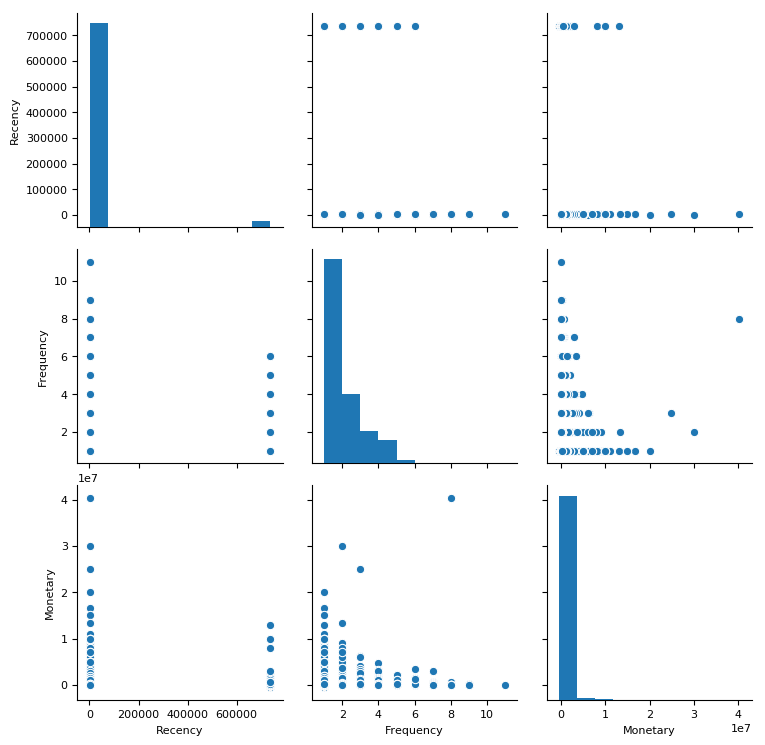

In [61]:
sns.pairplot(df_rfm)

C:\Users\nhatminh.phuong\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


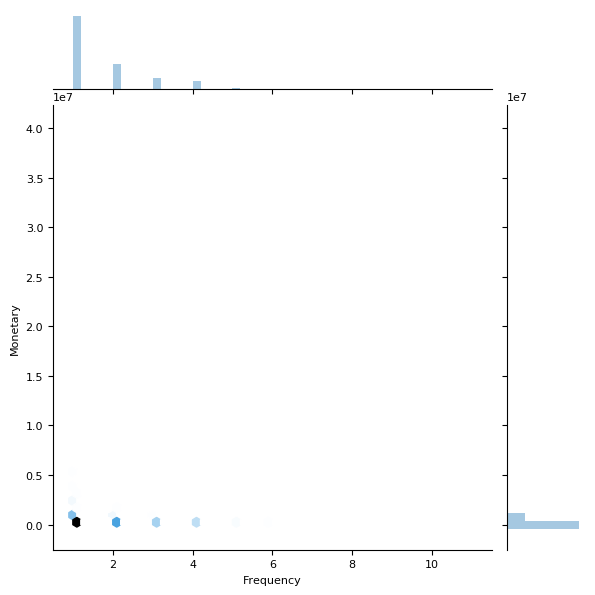

In [63]:
sns.jointplot(x='Frequency', y='Monetary',data=df_rfm, kind='hex')

In [184]:
def find_percentile(x,arr_val):
    if x <= np.percentile(arr_val,50):
        return 0
    elif x>= np.percentile(arr_val,50) and x < np.percentile(arr_val,75):
        return 1
    else: 
        return 2

In [186]:
df_output = df_rfm
freq = df_rfm['Frequency']
df_output['Stat_model'] = df_rfm.apply(lambda x: find_percentile(x['Frequency'],freq), axis=1)

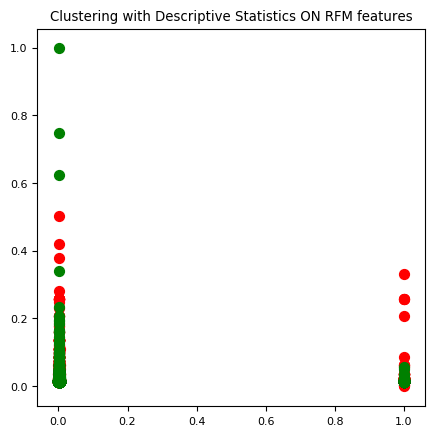

In [197]:
plt.scatter(X_rfm[df_output['Stat_model']==0,0],X_rfm[df_output['Stat_model']==0,2],s=50, c='red',label='Customer_segment1')
plt.scatter(X_rfm[df_output['Stat_model']==1,0],X_rfm[df_output['Stat_model']==1,2],s=50, c='blue',label='Customer_segment1')
plt.scatter(X_rfm[df_output['Stat_model']==2,0],X_rfm[df_output['Stat_model']==2,2],s=50, c='green',label='Customer_segment1')
plt.title('Clustering with Descriptive Statistics ON RFM features')
plt.show()

In [7]:
df_cmodel = df[['ENTRY_AGE',
 'COVER_AGE',
 'PAY_AGE',
 'OWNER_AGE',
 'PAY_TERM',
 'COVER_TERM',
 'INSURED_AMT',
 'PREMIUM',
 'PROPOSAL_TO_ISSUE',
 'ISSUE_TO_ST',
 'HEIGHT_CM',
 'WEIGHT_KG',
 'ANP',
 'PROD_TYPE_UL',
 'GENDER_M',
 'MEDICAL_FLAG_Y',
 'COVER_TYPE_Rider',
 'OWNER_GENDER_F',
 'OWNER_GENDER_M',
 'PAY_MODE_Cash/Check',
 'PAY_MODE_Credit Card Payment',
 'PAY_MODE_Others',
 'PAY_MODE_Salary Deduction',
 'PRODUCT_CATEGORY_Investment',
 'PRODUCT_CATEGORY_Protection',
 'PRODUCT_CATEGORY_Retirement',
 'PRODUCT_CATEGORY_Savings',
 'PAY_METHOD_Monthly',
 'PAY_METHOD_Quarterly',
 'PAY_METHOD_Semi-Annual',
 'PAY_METHOD_Single Pay',
 'LAST_UW_DEC_CANCELLED',
 'LAST_UW_DEC_DECLINED',
 'LAST_UW_DEC_OK TO ISSUE',
 'LAST_UW_DEC_POSTPONED',
 'QRY_APPS_RIDER',
 'QRY_TRAD_BASIC',
 'QRY_TRAD_RIDER',
 'QRY_UL_BASIC',
 'QRY_UL_RIDER',
 'CLASS_ORDER_1',
 'CLASS_ORDER_2',
 'CLASS_ORDER_3',
 'CLASS_ORDER_4',
 'CLASS_ORDER_5',
 'CLASS_ORDER_6',
 'CLASS_ORDER_7',
 'CLASS_ORDER_8',
 'CLASS_ORDER_9',
 'CLASS_ORDER_10',
 'RELATIONSHIP_BIN_EMPLOYER',
 'RELATIONSHIP_BIN_GRANDCHILDREN',
 'RELATIONSHIP_BIN_GRANDPARENTS',
 'RELATIONSHIP_BIN_MISSING',
 'RELATIONSHIP_BIN_OTHERS',
 'RELATIONSHIP_BIN_PARENTS',
 'RELATIONSHIP_BIN_RELATIVE',
 'RELATIONSHIP_BIN_SELF',
 'RELATIONSHIP_BIN_SIBLINGS',
 'RELATIONSHIP_BIN_SPOUSE',
 'REGION_DUMMY_REGION_1',
 'REGION_DUMMY_REGION_10',
 'REGION_DUMMY_REGION_11',
 'REGION_DUMMY_REGION_12',
 'REGION_DUMMY_REGION_13',
 'REGION_DUMMY_REGION_14',
 'REGION_DUMMY_REGION_15',
 'REGION_DUMMY_REGION_16',
 'REGION_DUMMY_REGION_17',
 'REGION_DUMMY_REGION_18',
 'REGION_DUMMY_REGION_19',
 'REGION_DUMMY_REGION_2',
 'REGION_DUMMY_REGION_20',
 'REGION_DUMMY_REGION_21',
 'REGION_DUMMY_REGION_22',
 'REGION_DUMMY_REGION_23',
 'REGION_DUMMY_REGION_3',
 'REGION_DUMMY_REGION_4',
 'REGION_DUMMY_REGION_5',
 'REGION_DUMMY_REGION_6',
 'REGION_DUMMY_REGION_7',
 'REGION_DUMMY_REGION_8',
 'POL_ST_cancelled',
 'POL_ST_claimed',
 'POL_ST_declined',
 'POL_ST_did not push through',
 'POL_ST_encoded complete',
 'POL_ST_encoded w/ reqt',
 'POL_ST_expired',
 'POL_ST_for issuance',
 'POL_ST_for underwriting',
 'POL_ST_inforce',
 'POL_ST_lapsed',
 'POL_ST_lapsed - apl',
 'POL_ST_lapsed - eti',
 'POL_ST_lapsed - rpu',
 'POL_ST_matured',
 'POL_ST_not taken up',
 'POL_ST_postponed',
 'POL_ST_surrendered',
 'POL_ST_surrendered - ecv',
 'POL_ST_surrendered - rpu',
 'POL_ST_with uw requirements']]

In [12]:
X = MinMaxScaler(feature_range=(0,1),copy=True).fit_transform(df_cmodel)

C:\Users\nhatminh.phuong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [13]:
X

array([[0.45333333, 0.32110092, 0.32110092, ..., 0.        , 0.        ,
        0.        ],
       [0.70666667, 0.53211009, 0.53211009, ..., 0.        , 0.        ,
        0.        ],
       [0.78666667, 0.55045872, 0.55045872, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.16      , 0.1559633 , 0.1559633 , ..., 0.        , 0.        ,
        0.        ],
       [0.16      , 0.1559633 , 0.1559633 , ..., 0.        , 0.        ,
        0.        ],
       [0.16      , 0.11009174, 0.11009174, ..., 0.        , 0.        ,
        0.        ]])

In [68]:
X_rfm =  MinMaxScaler(feature_range=(0,1),copy=True).fit_transform(df_rfm[df_rfm.columns])

C:\Users\nhatminh.phuong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


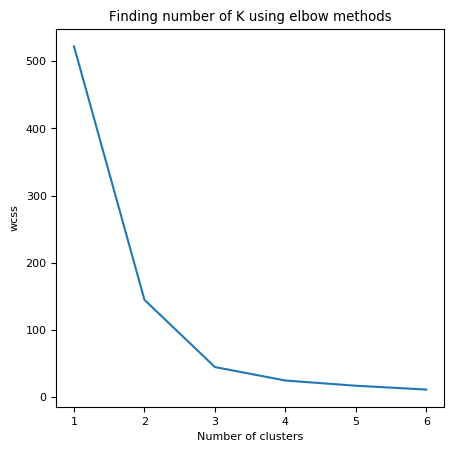

In [71]:
wcss = []
for i in range(1,7):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=100)
    km.fit(X_rfm)
    wcss.append(km.inertia_)
plt.plot(range(1,7),wcss)
plt.title('Finding number of K using elbow methods')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

Text(0.5,1,'Clustering with K = 3 on RFM features')

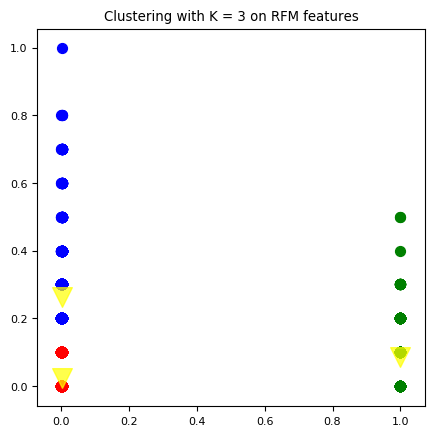

In [149]:
km3=KMeans(n_clusters=3,init='k-means++', max_iter=100)
y_means_3 = km3.fit_predict(X_rfm)
plt.scatter(X_rfm[y_means_3==0,0],X_rfm[y_means_3==0,1],s=50, c='red',label='Customer_segment1')
plt.scatter(X_rfm[y_means_3==1,0],X_rfm[y_means_3==1,1],s=50, c='green',label='Customer_segment2')
plt.scatter(X_rfm[y_means_3==2,0],X_rfm[y_means_3==2,1],s=50, c='blue',label='Customer_segment3')
plt.scatter(km3.cluster_centers_[:,0], km3.cluster_centers_[:,1],s=200,marker='v', c='yellow', alpha=0.7, label='Centroids')
plt.title('Clustering with K = 3 on RFM features')

Text(0.5,1,'Clustering with K = 4 on RFM features')

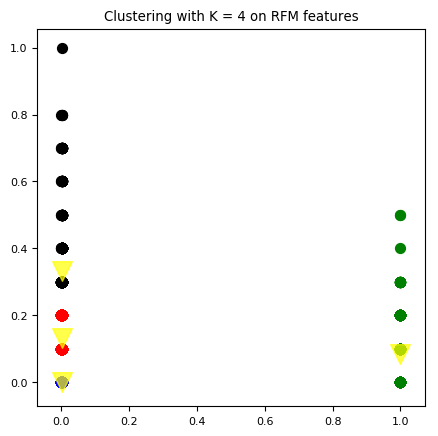

In [198]:
km4=KMeans(n_clusters=4,init='k-means++', max_iter=100)
y_means_4 = km4.fit_predict(X_rfm)
plt.scatter(X_rfm[y_means_4==0,0],X_rfm[y_means_4==0,1],s=50, c='red',label='Customer_segment1')
plt.scatter(X_rfm[y_means_4==1,0],X_rfm[y_means_4==1,1],s=50, c='green',label='Customer_segment2')
plt.scatter(X_rfm[y_means_4==2,0],X_rfm[y_means_4==2,1],s=50, c='blue',label='Customer_segment3')
plt.scatter(X_rfm[y_means_4==3,0],X_rfm[y_means_4==3,1],s=50, c='black',label='Customer_segment4')
plt.scatter(km4.cluster_centers_[:,0], km4.cluster_centers_[:,1],s=200,marker='v', c='yellow', alpha=0.7, label='Centroids')
plt.title('Clustering with K = 4 on RFM features')

In [107]:

df_output['kmeans_3'] = y_means_3
df_output['kmeans_4'] = y_means_4

In [88]:
df_output.head()

,Recency,Frequency,Monetary,kmeans_3,kmeans_4
INSURED_ID,,,,,
PART_ID_10,3044,1,25785.12,0,2
PART_ID_10000,1629,1,100000.00,0,2
PART_ID_10001,1651,1,1000000.00,0,2
PART_ID_10002,1298,2,63183.28,0,0
PART_ID_10003,1201,3,66267.04,2,0


In [95]:
for i in ['kmeans_3','kmeans_4']:
    print('===================================')
    print('Differentiating between clusters in method: ' + i )
    for j in df_output[i].unique():
        df_tmp = df_output[df_output[i]==j]
        print('Group '+ str(j) + ' Mean recency of group is ' + str(df_tmp['Recency'].mean())
              + '\nMean frecency of group is ' + str(df_tmp['Frequency'].mean())
              + '\nMean monetary of group is ' + str(df_tmp['Monetary'].mean()))
        print()
    print()

Differentiating between clusters in method: kmeans_3
Group 0 Mean recency of group is 2047.3160372530958
Mean frecency of group is 1.249718554907379
Mean monetary of group is 360457.5193071339

Group 2 Mean recency of group is 2401.5511152416357
Mean frecency of group is 3.6319702602230484
Mean monetary of group is 148157.61887081803

Group 1 Mean recency of group is 737170.0
Mean frecency of group is 1.854219948849105
Mean monetary of group is 291272.0064961637


Differentiating between clusters in method: kmeans_4
Group 2 Mean recency of group is 1978.4450961669622
Mean frecency of group is 1.0
Mean monetary of group is 407900.90528168046

Group 0 Mean recency of group is 2263.1422958181306
Mean frecency of group is 2.315183833847881
Mean monetary of group is 196810.13940499572

Group 3 Mean recency of group is 2531.4927113702624
Mean frecency of group is 4.321671525753159
Mean monetary of group is 145101.60703595728

Group 1 Mean recency of group is 737170.0
Mean frecency of group i

In [104]:
silhouette_avg = silhouette_score(X_rfm, y_means_3)
print("For n_clusters =3 ","The average silhouette_score is :", silhouette_avg)

For n_clusters =3  The average silhouette_score is : 0.7642060931237917


In [100]:
silhouette_avg = silhouette_score(X_rfm, y_means_4)
print("For n_clusters =4 ","The average silhouette_score is :", silhouette_avg)

For n_clusters =4  The average silhouette_score is : 0.8002334522961642


In [109]:
db3 = DBSCAN(eps=3, min_samples=5)
y_db_3 = db3.fit_predict(X)

In [114]:
set(y_db_3)

{0}

In [121]:
db3 = DBSCAN(eps=0.5, min_samples=2)
y_db_3 = db3.fit_predict(X_rfm)

In [122]:
set(y_db_3)

{-1, 0, 1}

In [162]:
db3.core_sample_indices_

array([    0,     1,     2, ..., 12311, 12312, 12313], dtype=int64)

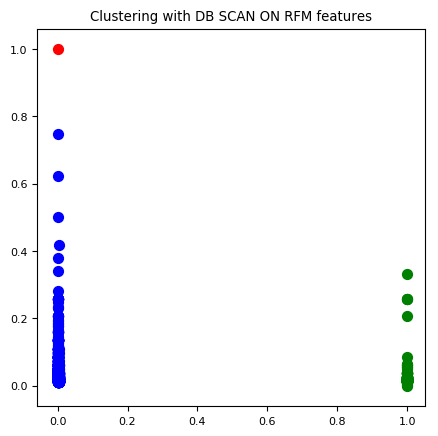

In [172]:
plt.scatter(X_rfm[y_db_3==-1,0],X_rfm[y_db_3==-1,2],s=50, c='red',label='Customer_segment1')
plt.scatter(X_rfm[y_db_3==0,0],X_rfm[y_db_3==0,2],s=50, c='blue',label='Customer_segment1')
plt.scatter(X_rfm[y_db_3==1,0],X_rfm[y_db_3==1,2],s=50, c='green',label='Customer_segment1')
plt.title('Clustering with DB SCAN ON RFM features')
plt.show()

In [200]:
silhouette_avg = silhouette_score(X_rfm, y_db_3)
print("For DBSCAN n_clusters =3 ","The average silhouette_score is :", silhouette_avg)

For DBSCAN n_clusters =3  The average silhouette_score is : 0.8964222078602517


In [165]:
df_output['DBSCAN'] = y_db_3

In [166]:
for i in ['DBSCAN']:
    print('===================================')
    print('Differentiating between clusters in method: ' + i )
    for j in df_output[i].unique():
        df_tmp = df_output[df_output[i]==j]
        print('Group '+ str(j) + ' Mean recency of group is ' + str(df_tmp['Recency'].mean())
              + '\nMean frecency of group is ' + str(df_tmp['Frequency'].mean())
              + '\nMean monetary of group is ' + str(df_tmp['Monetary'].mean()))
        print()
    print()

Differentiating between clusters in method: DBSCAN
Group 0 Mean recency of group is 2111.2541519879214
Mean frecency of group is 1.67916456970307
Mean monetary of group is 318782.02373427356

Group 1 Mean recency of group is 737170.0
Mean frecency of group is 1.854219948849105
Mean monetary of group is 291272.0064961637

Group -1 Mean recency of group is 2091.0
Mean frecency of group is 8.0
Mean monetary of group is 40346330.0




In [170]:
SpC_3= SpectralClustering(n_clusters=3)
y_spc_3 = SpC_3.fit_predict(X_rfm)

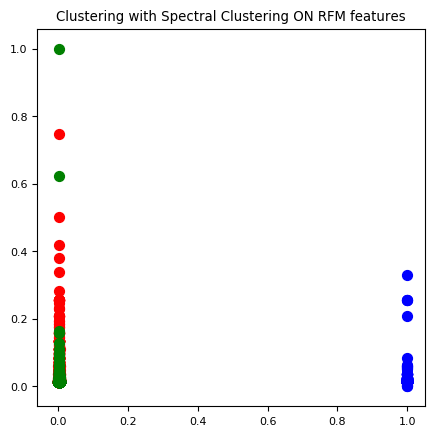

In [199]:
plt.scatter(X_rfm[y_spc_3==0,0],X_rfm[y_spc_3==0,2],s=50, c='red',label='Customer_segment1')
plt.scatter(X_rfm[y_spc_3==1,0],X_rfm[y_spc_3==1,2],s=50, c='blue',label='Customer_segment1')
plt.scatter(X_rfm[y_spc_3==2,0],X_rfm[y_spc_3==2,2],s=50, c='green',label='Customer_segment1')
plt.title('Clustering with Spectral Clustering ON RFM features')
plt.show()

In [181]:
df_output['Spectral_Clustering'] = y_spc_3

In [183]:
for i in ['Spectral_Clustering']:
    print('===================================')
    print('Differentiating between clusters in method: ' + i )
    for j in df_output[i].unique():
        df_tmp = df_output[df_output[i]==j]
        print('Group '+ str(j) + ' Mean recency of group is ' + str(df_tmp['Recency'].mean())
              + '\nMean frequency of group is ' + str(df_tmp['Frequency'].mean())
              + '\nMean monetary of group is ' + str(df_tmp['Monetary'].mean()))
        print()
    print()

Differentiating between clusters in method: Spectral_Clustering
Group 0 Mean recency of group is 2047.3160372530958
Mean frequency of group is 1.249718554907379
Mean monetary of group is 360457.5193071339

Group 2 Mean recency of group is 2401.5511152416357
Mean frequency of group is 3.6319702602230484
Mean monetary of group is 148157.61887081803

Group 1 Mean recency of group is 737170.0
Mean frequency of group is 1.854219948849105
Mean monetary of group is 291272.0064961637




In [202]:
silhouette_avg = silhouette_score(X_rfm, y_spc_3)
print("For Spectral Clustering n_clusters =3 ","The average silhouette_score is :", silhouette_avg)

For Spectral Clustering n_clusters =3  The average silhouette_score is : 0.7642060931237917


In [190]:
df_output.to_excel('../data/processed/output/customer_segmentation.xlsx')

# EXPERIMENT WITH WHOLE DATASET

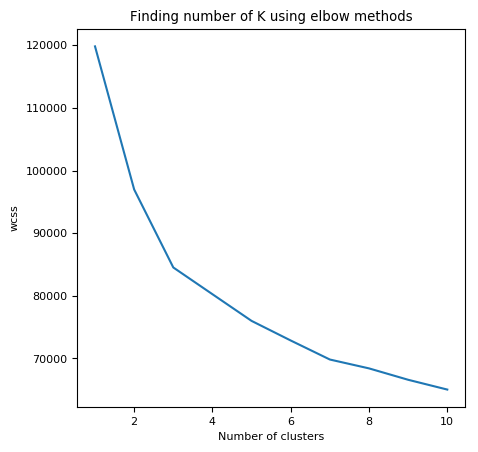

In [17]:
wcss = []
for i in range(1,11):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=100)
    km.fit(X)
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss)
plt.title('Finding number of K using elbow methods')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

In [141]:
km3=KMeans(n_clusters=3,init='k-means++', max_iter=100)
y_means_3 = km3.fit_predict(X)

Text(0.5,1,'Clustering with K = 3 on all features')

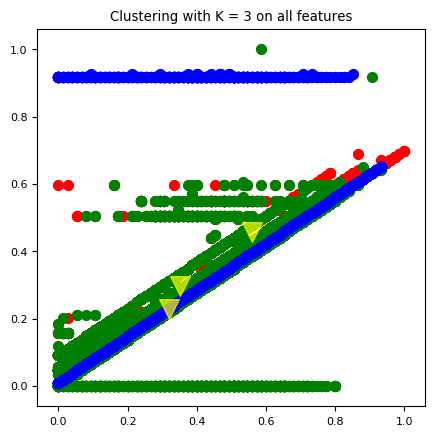

In [146]:
plt.scatter(X[y_means_3==0,0],X[y_means_3==0,1],s=50, c='red',label='Customer_segment1')
plt.scatter(X[y_means_3==1,0],X[y_means_3==1,1],s=50, c='green',label='Customer_segment2')
plt.scatter(X[y_means_3==2,0],X[y_means_3==2,1],s=50, c='blue',label='Customer_segment3')
plt.scatter(km3.cluster_centers_[:,0], km3.cluster_centers_[:,1],s=200,marker='v', c='yellow', alpha=0.7, label='Centroids')
plt.title('Clustering with K = 3 on all features')

In [27]:
km4=KMeans(n_clusters=4,init='k-means++', max_iter=100)
y_means4 = km4.fit_predict(X)

Text(0.5,1,'Clustering with K = 4 on all features')

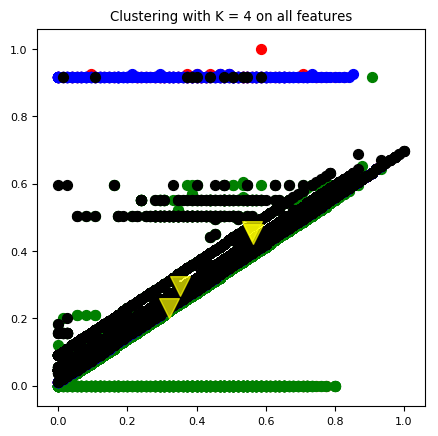

In [73]:
plt.scatter(X[y_means4==0,0],X[y_means4==0,1],s=50, c='red',label='Customer_segment1')
plt.scatter(X[y_means4==1,0],X[y_means4==1,1],s=50, c='green',label='Customer_segment2')
plt.scatter(X[y_means4==2,0],X[y_means4==2,1],s=50, c='blue',label='Customer_segment3')
plt.scatter(X[y_means4==3,0],X[y_means4==3,1],s=50, c='black',label='Customer_segment4')
plt.scatter(km4.cluster_centers_[:,0], km4.cluster_centers_[:,1],s=200,marker='v', c='yellow', alpha=0.7, label='Centroids')
plt.title('Clustering with K = 4 on all features')